In [1]:
from IPython.display import Image, Audio
import matplotlib.pyplot as plt

## Extracting frequency information

### Chromagrams

Chromagrams are a representation of the energy of a signal in terms of its pitch class (chroma) content. Therefore, the entire spectrum is projected onto 12 bins representing the 12 distinct semitones (or chroma) of the octave. **The chroma representation tells us the intensity of each of the 12 distinct musical chroma of the octave at each time frame.**

They are very useful in a number of frequency-related tasks, such as key detection, chord dectection, and cover song ID, because they capture harmonic and melodic characteristics of music, while being robust to changes in timbre and instrumentation.

Within signal processing, chroma-based audio features are sometimes (confusingly, and somewhat incorrectly) referred to as "pitch class profiles" --- more on that later.

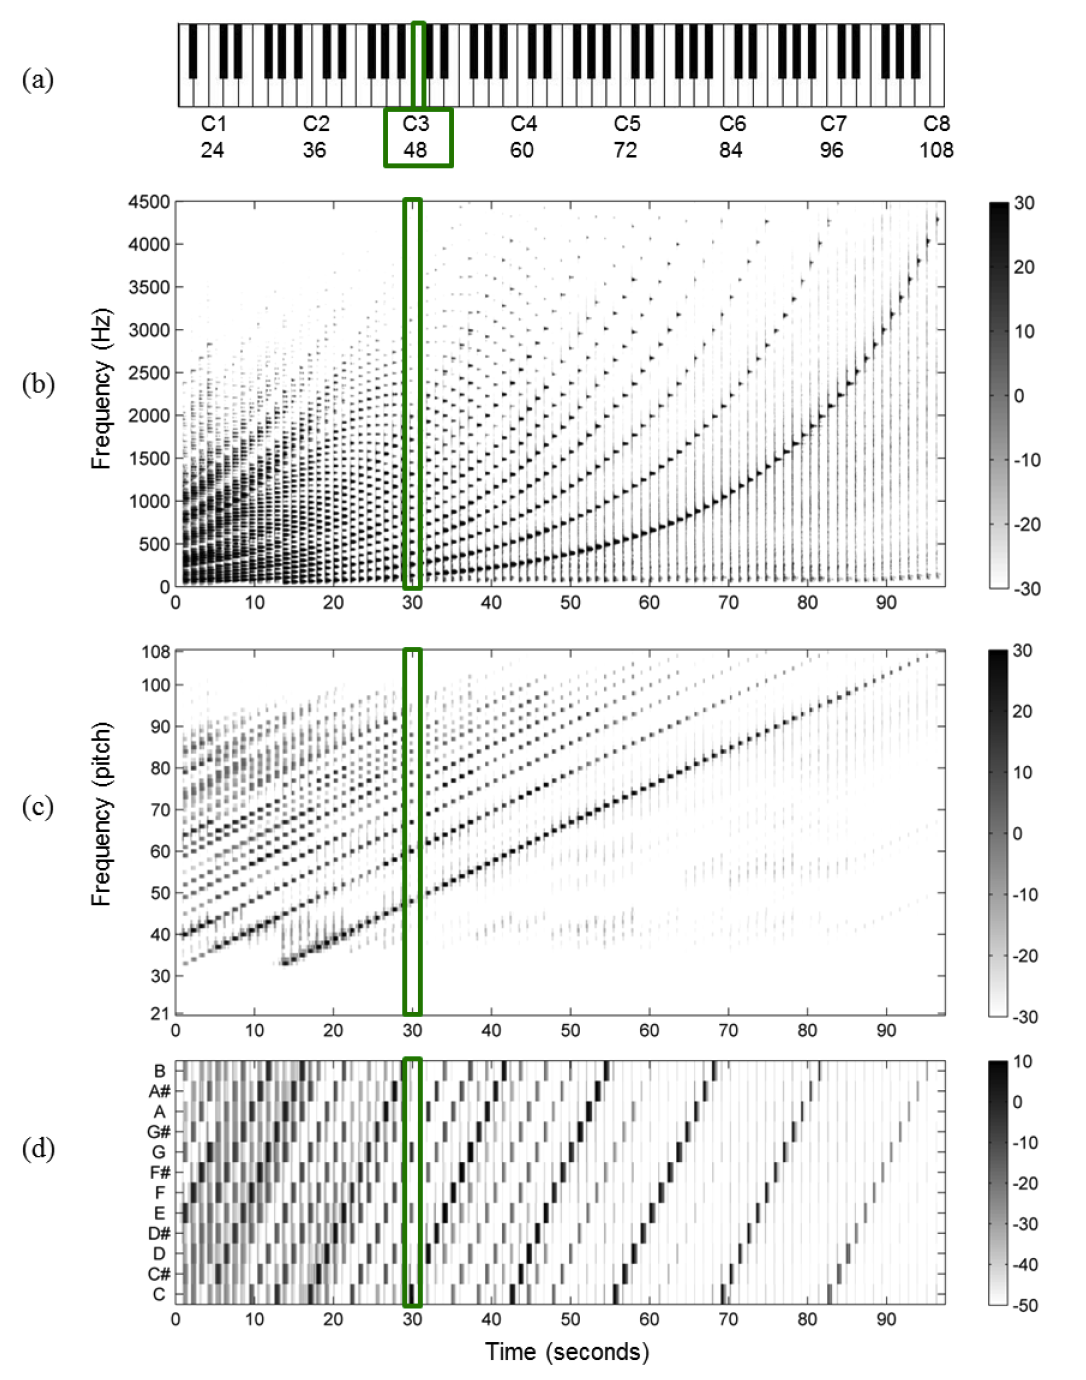

In [2]:
#Full chromatic scale according to three "pitch content" views
Image('../images/chromagram.png', width=800)

To calculate a chromagram, we take a spectrogram and convert the linear frequency axis to a logarithmic one. The signal is decomposed into a large number of equally-spaced frequency bands with center frequencies typically corresponding to the pitches A0 (midi 21) to C8 (midi 108) (or the 88 piano keys), such that each band is a semitone. 

The chroma content is then calculated by summing the *log-frequency* magnitude spectrum across pitches that have an octave relation (e.g., sum A0 + A1 + A2 ... to get the energy for how much "A" there is in a signal.)

When MIR people say "pitch class profiles" they are referring to how much energy in the signal there is at each pitch class. In music perception and cognition, "pitch class profiles" are perceptually derived scales of how well each scale degree "fits" in a tonal key.

In [3]:
from scipy.io.wavfile import read
from scipy import signal

(fs, x) = read('../uploaded_files/femaleSingingScale.wav')
(fs2, x2) = read('../uploaded_files/piano.wav')
newx = x[:len(x)//2].astype(float) #cut length, convert to float for librosa
#newx = signal.resample(x, len(x)//2).astype(float)


In [4]:
Audio(newx, rate=fs)

In [5]:
Audio(x2, rate=fs)

Spectrogram with frequency axis on a log scale:

Text(0.5, 1.0, 'Piano')

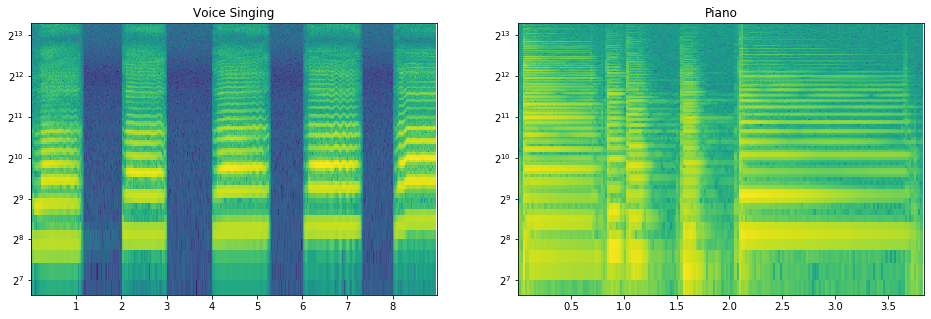

In [6]:
#Vocals
plt.figure(figsize=(16,5))
ax = plt.subplot(1,2,1)
plt.specgram(newx, NFFT=1028, Fs=44100, mode='magnitude', scale='dB');
ax.set_yscale('log', basey=2)#change y axis to log scale
ax.set_ylim(100,10050)#manually set ylimits - default cuts off inappropriately
plt.title('Voice Singing')
ax2 = plt.subplot(1,2,2)
plt.specgram(x2, NFFT=1028, Fs=44100, mode='magnitude', scale='dB');
ax2.set_yscale('log', basey=2)#change y axis to log scale
ax2.set_ylim(100,10050)#manually set ylimits - default cuts off inappropriately
plt.title('Piano')

Notice, however, that this converts the axis, but not the size of the bins. The bins were computed such that each frame represented a fixed frequency resolution N/fs Hz wide. In order to build a chromagram, we first need to compute a STFT where ideally each bin gets larger and larger (in Hz) to account for the fact that pitch is logarithmic, and we would like to compute a STFT such that each bin is roughly one semitone "pitch" (or 100 cents) wide.

Therefore we assign each spectral coefficient $X(m,k)$ to the pitch with center frequency that is closest to the frequency $F_{coef}(k)$. For each pitch with semitone indices 0:127 (all possible MIDI):

$$P(p)= \{k \in[0:K]:{F_{pitch}(p - 0.5)\leq F_{coef}(k) \lt F_{pitch} (p + 0.5)}\}$$

Where $F_{pitch}(p)$ is defined by the common MIDI to frequency formula:

$$2^{(p-69)/12}*440$$

So for MIDI note $p = 69$ ...

In [7]:
high = 2**(0.5/12)*440
low = 2**(-0.5/12)*440
print(low,high)

427.4740541075866 452.8929841231365


for MIDI note $p = 100$

In [8]:
high = 2**((100.5-69)/12)*440
low = 2**((99.5-69)/12)*440
print(low,high)

2561.9496018022496 2714.2910527179756


...the center frequency $F_{pitch}(p=69) = 440$, and the cutoff frequencies are $F_{pitch}(p-0.5=68.5) = 427.47$  and   
$F_{pitch}(p+0.5=69.5) = 452.89$   
meaning the bandwidth would be $25.41 Hz$ at that part of the frequency spectrum.

The set $P(p)$ consists of all Fourier coefficients that lie within these bounds. In this case, if we did an STFT with a sample rate of 44100 and an analysis window of 4096 samples, then we know that each bin would be ~ 10.7 Hz wide. Thus, the coefficients would be each index multiplied by ~10.7:<br> 
0 = 0<br>
1 = 10.7 Hz <br> 
2 = 21.5 Hz<br>
3 = 32.3 Hz<br>
...<br>
**40 = 430.6 <br>
41 = 438.7 <br>
42 = 449.4<br>**
43 = 460.1<br>

Thus the set $P(p)$ would be the indices that fall within the bandwidth of p = 69, therefore, $p(p) = \{40,41,42\}$ And the spectrogram is computed by summing all coefficients in a similar fasion until we have a spectrogram according to semitone or MIDI values.

Fortunately, there are algorithms that can do this for us. We will be using the Librosa package to compute chromagrams, and below you can see two of my approaches to plotting them. (Note that, like spectrogram, we tend to use the same word for both the values and the graphs). 

### Librosa functions

Librosa has three *varieties* for computing chromagrams, but we will just be using this one:

* librosa.feature.chroma_stft  

This is the 'basic' chromagram computation as explained (and computed) above.

You must pass either a $y$ value to `feature.chroma_stft` which would be an audio signal, or else an $S$ value, which would be a pre-computed energy (magnitude) spectrum (i.e., STFT via `numpy`)

Package details [here](https://librosa.github.io/librosa/generated/librosa.feature.chroma_stft.html)

In [9]:
from librosa import feature
'''Note that librosa assumes you will downsample, and the default sample rate is 22050
If you want to use an original sample rate of 44.1kHz you must specify the sr rate'''

#creates the cromagram from raw audio
chromagram1 = feature.chroma_stft(y=newx, n_fft=2048, sr=44100)
chromagram1 # output = vector of vectors

array([[0.17718916, 0.26999778, 0.09942651, ..., 0.20954509, 0.21034266,
        0.24726379],
       [0.24335955, 0.06430326, 0.01638417, ..., 0.00192821, 0.00779127,
        0.04515412],
       [0.08724321, 0.01654533, 0.00273622, ..., 0.00450839, 0.00884693,
        0.02558063],
       ...,
       [0.4838029 , 0.85242945, 1.        , ..., 0.01873487, 0.02755349,
        0.06388713],
       [1.        , 1.        , 0.9743975 , ..., 0.16786027, 0.20246461,
        0.31108612],
       [0.58357656, 0.57174426, 0.4133293 , ..., 1.        , 0.9741207 ,
        0.5537272 ]], dtype=float32)

The result is a chroma *vector* representation which is a 12-element vector, where each element represents the
spectral energy corresponding to one pitch class (i.e. C, C#, D, D#, etc.). The chromagram is a vector of vectors or multidimensional array with a chroma vector for each STFT window.

In [10]:
x2 = x2.astype(float) #convert to float for librosa
chromagram2 = feature.chroma_stft(y=x2, n_fft=2048,sr=44100)

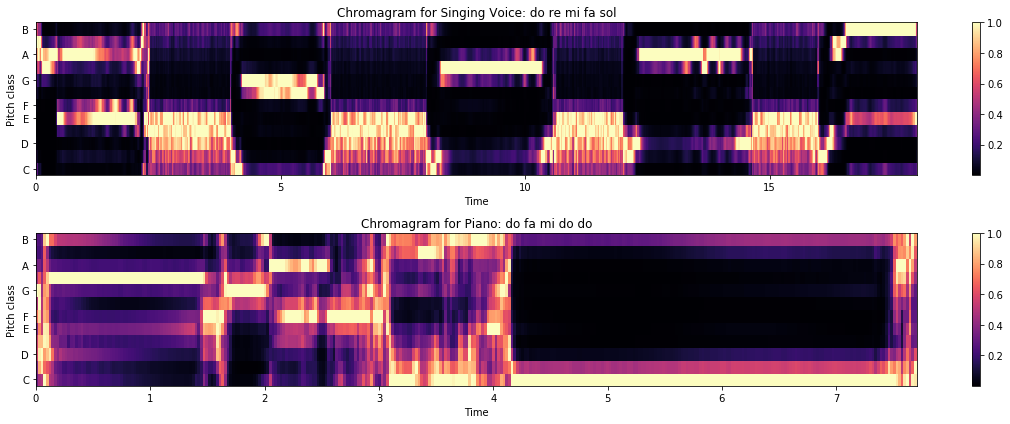

In [11]:
from librosa import display # useful for showing chromagram
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
ax = plt.subplot(2,1,1)
display.specshow(chromagram1, y_axis='chroma', x_axis='time') # this creates the graph
plt.colorbar() #this adds the legend
plt.title('Chromagram for Singing Voice: do re mi fa sol')
ax = plt.subplot(2,1,2)
display.specshow(chromagram2, y_axis='chroma', x_axis='time') # this creates the graph
plt.colorbar() #this adds the legend
plt.title('Chromagram for Piano: do fa mi do do')
plt.tight_layout()

You may notice that it doesn't look too good! Although chromagrams are used in a lot of MIR tasks, and over a larger set of data work fairly well, there are some known issues:

1) Generally, higher sounds emit a "cleaner" spectrum than lower sounds. For lower notes, the signal's energy is often contained in higher harmonics. Thus, when we add across pitch class bins, we may estimate the 'wrong' fundamental and instead get the pitch value of the high-energy harmonic(s) (or just a mess).

2) Vocal sounds are known to be problematic for similar reasons, in that often energy is contained in harmonics above the fundamental known as **formants** corresponding to a resonance in the vocal tract. (Also close mic placement can over-emphasize energy in certain frequency bands as well.)

3) Limitation of chroma for multi-part music...

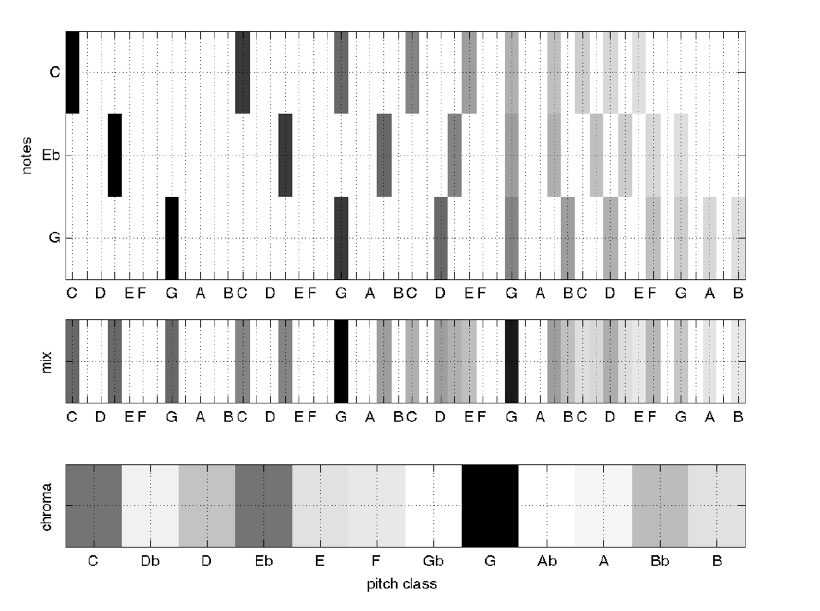

In [12]:
Image('../images/chroma_polyphonic.png', embed=True)

The chroma vectors depend on the pitch classes of strong partials in the signal. When many events happen over a single window, this can be problematic (overly reductive). Likewise, when louder events mask "harmonically important" quieter events, this can produce misleading key data.

### Key Detection
One major use for chromagram data is in automatic key detection tasks. The most common model is that chromagrams are computed from some file or excerpt, and each chromagram is evaluated against some kind of pitch class distribution (usually also called "key profiles" or "pitch class profiles" or "theoretical profiles" for all 24 musical (major-minor) keys. (The one below has averaged all major and minor keys respectively and represents scale-degree rather than chroma).

#### Krumhansl-Kessler Key Profiles (i.e., "KK profiles")
Krumhansl and Kessler did a famous study in the 80s, and their profiles are still one of the most widely-used today. They are widely used because they are one of the only set of values  **based on human perception.**  

The basic idea was that, over several experiments, they asked people to rate how well a particular note "fit" following a particular cadential chord progression. The "profile" then, is the averaged ratings by chromatic scale degree (see below).

These profiles have been shown to be highly correlated with actual pitch class distributions for classical pieces. (I.e., if we count up all the notes in a Mozart sonata in C major, and report the distribution of scale-degrees as a proportion, the shape would look a lot like the profile on the left).

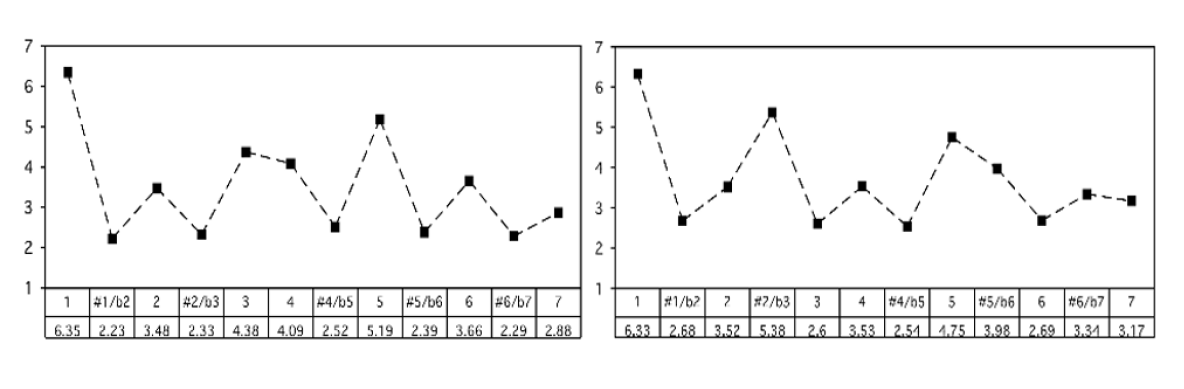

In [13]:
from IPython.display import Image
Image('../images/kk_profiles.png', embed=True)
#Major profile on left, Minor profile on right

#### Challenges
There are many reasons that automatic key detection is a non-trivial task for a computer. The biggest challenge for automatic key detection systems is that it can even be a challenging task for humans! For instance, when a piece has changes of the key (modulations) and/or many notes that are outside of the theoretical note distribution of the key, the order and timing of notes becomes very important.

Currently key detection works best for popular music that stays (mostly) within a single key for the duration of the piece, or music where the largest proportion of the song stays in one key. They also tend to work slightly better with a larger window for finer spectral resolution (e.g., fft size =~ 4096-8192) and a fairly large overlap of 50% or higher.

Chromagrams are typically generated with A=440 tuning, and so any recording that deviates from this will need to be adjusted. (See Librosa package details for how to do that!)

Audio Key detection systems can be grouped into the following four categories: 

* Pattern matching approaches 
* Template-based methods  (e.g., correlation)
* Geometric models   
* Hidden Markov Models (HMMs)  


#### Pattern matching

Typically based on partial transcription of the audio signal to score representation for use with symbolic data methods. These do not use chromagrams at all, so we won't discuss them here.

#### Template-based methods
These models are based on correlating the global distribution of pitch-classes for a piece of music with representative templates for each key (such as the KK-profiles). Sometimes distributions are multiplied by different *weightings* and then compared against some template representing the ideal distribution. The key corresponding to
the template with maximum correlation to the pitch-class distribution feature is then chosen.

*This is the method that you will likely use*

The templates are either based on music theory models, cognitive-based models, or statistical models (or hybrids of these).

#### Geometric models

Estimates keys based on mapping of FFT (spectral) data to spatial distances within some spatial model (e.g., a helix; a torus, etc.).  

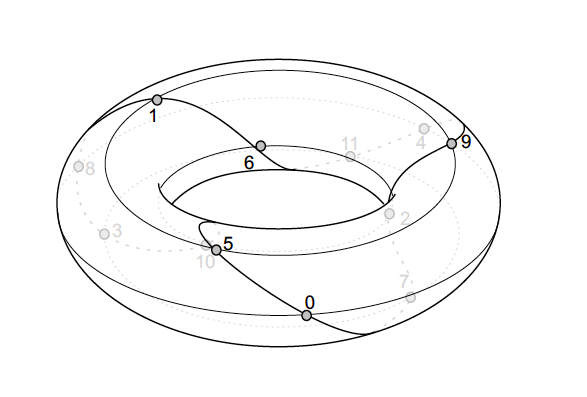

In [14]:
Image('../images/hypertorus.png', embed=True)

#### HMMs

Evaluates various features and their contexts to best predict some likely "state." (For example, if you were not sick yesterday and today you started sneezing and coughing, we might try to predict whether your state is "allergic reaction" or "ill" based on context-- like maybe you were outside or inside.)

Therefore these types of systems will often also incorporate some form of chord detection or local key estimation (i.e., detection of modulations).